# 1 -  Planejamento da Solução

## Entendimento de Negócio

**Qual é o problema de negócio?**

- Empresa alimentícia situada no RJ, deseja abrir filiais na cidade de São Paulo. Para isso, precisa de 3 análises:
    - 1 - Estimar faturamento que uma loja teria em cada um dos bairros de São Paulo (regressão, neste caso sem séries temporais).
    - 2 - Classificar o potencial dos bairros de São Paulo em alto, médio ou baixo (classificação multiclasse).
    - 3 - Segmentar os bairros de São Paulo de acordo com o perfil de renda e idade, identificando os com maior aderência ao público alvo.
    
- Público alvo: adultos de 25 a 50 anos, das classes A (rendas A1 e A2) e B (rendas B1 e B2). 

**Saída**

- Prototipagem técnica da solução: https://docs.google.com/spreadsheets/d/17lxCBRLPEuNCO25BimVFRE3Tms-314WSTpJ1xgEIf38/edit#gid=0

- O que será entregue, efetivamente? / Onde o time de negócio quer ver?
    - Documento no formato doc, pdf ou ppt, voltado ao negócio, apresentando um racional de como os dados foram analisados. Detalhar com gráficos, tabelas, e descrever conclusões.
    - Responder: Dada a natureza do problema apresentado, que outro dado externo (fontes públicas ou privadas) poderia ser utilizado para agregar mais valor ao resultado? Por que?
    
**Entrada**
- Fontes de dados:
    - Dataset contendo faturamento e potencial dos bairros do Rio de Janeiro do cliente, bem como dados sociodemográficos do bairros do Rio de Janeiro e São Paulo.

- Ferramentas:
    - Python 3.8.12, Jupyter Notebook, Git, Github.

**Processamento**
- Tipo de problema: análise exploratória, regressão, classificação e clusterização.
- Metodologia: CRISP-DM, metodologia ágil (iterativa e incremental) para desenvolvimento de projetos de ciência de dados.


## Implementado nesta Sprint

**Ciclo 5**

Desenvolvimento da Análise 3 (clusterização):

- Seleção de Features.
- Novo K-Means + comparação com o baseline do ciclo 1.
- Modelagem de dados (data preparation).
- Análise de Silhueta do K-Means e considerações.
- Criação de novo perfil de clusters, identificando os bairros de SP com maior aderência ao público alvo, e gerando relatório sinalizando quais são, jundamente com as análises 1 e 2.

# 2 - Importações

## Bibliotecas

In [315]:
import pandas                      as pd 
import seaborn                     as sns
import numpy                       as np
import sweetviz                    as sv
import umap.umap_                  as umap
import inflection
import warnings

from IPython.core.display          import HTML
from matplotlib                    import pyplot as plt
from tabulate                      import tabulate
from matplotlib.ticker             import FuncFormatter
from IPython.display               import Image

from sklearn.cluster               import KMeans
from sklearn.preprocessing         import MinMaxScaler
from yellowbrick.cluster           import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics               import silhouette_score

## Funções Auxiliares

In [2]:
def jupyter_settings():
    """ Otimiza configurações gerais, padronizando tamanhos de plots, etc """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
    pd.set_option('display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('max_colwidth', None)
    sns.set()
jupyter_settings()

# 3 - Análise 3: Segmentação por perfil de renda e idade em SP

Análise 3 - Segmentar os bairros de São Paulo de acordo com o perfil de renda e idade, identificando os com maior aderência ao público alvo.

O conteúdo desta próxima seção refere-se ao ciclo 1. Não será alterado, para comparação de desempenho contra as melhorias que serão implementadas neste ciclo 5.

Agora, serão implementados os itens de melhoria citados no ciclo 1, visando aumentar a métrica SS da clusterização. O primeiro passo será a filtragem de variáveis, a seguir.

##  Modelo Baseline (Ciclo 1)

Trata-se portanto de um problema de clusterização (não supervisionado). 

- Nesta tarefa, não há divisão do dataset, sendo passados todos os dados ao modelo, que encontra grupos (clusters) a partir deles.
- Diferentemente das análises anteriores, aqui será utilizado o dataset df_sp, a fim de realizar a segmentação destes bairros.
- Diferentes modelos serão utilizados, sendo neste primeiro ciclo escolhido o K-Means, disponível na biblioteca scikit-learn.

### K-Means

O K-Means (K-médias) possui este nome, porque utiliza centróides, que são o ponto central (médio) do cluster.

Funcionamento: 
- A partir do número de K informado, o K-means criará k centroides aleatoriamente no espaço de dados, que serão os grupos. 
- Serão então calculadas as distâncias de todos os pontos em relação a cada um dos centroides.
- Cada ponto assumirá o rótulo do centroide mais próximo a ele, passando a pertencer a aquele grupo.
- Ao fim do processo, reposiciona-se o centróide no centro do cluster, recalcula-se as distênaicas e atribuição dos pontos aos grupos.
- Quando o centroide convergir e os pontos pararem de ser atribuídos a outro cluster, o agrupamento está concluído.

Características:
- O número de K (grupos) é uma parâmetro.
- Serão gerados sempre clusters convexos, pelo fato de utilizar o raio para calcular as distâncias.
- Assume sempre que os cluster possuem o mesmo diâmetro.
- Como a inicialização dos centróides é aleatória, pode formar grupos distintos conforme a sua posição inicial. Isto pode ser atenuado pelo parâmetro "n_init", que define o número de inicializações aleatórias, e retorna o melhor resultado.
- Necessita que os dados estejam na mesma escala (ou muito próxima), evitando a distorção dos cálculos de distâncias.
- É sensível a outliers, demandando remoção ou tratativa destes.



Clusterizar apenas perfil de renda e idade do público alvo da empresa.

In [55]:
df_sp.head(2)

,codigo,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501,NaN,NaN
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920,NaN,NaN


In [57]:
df_seg = df_sp[["pop_de25a34","pop_de35a49","domicilios_a1","domicilios_a2","domicilios_b2","domicilios_b2"]]
print(df_seg.shape)
df_seg.head(1)

(296, 6)


,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b2,domicilios_b2
160,14535,21549,0,253,4368,4368


Instanciar o KMeans, treinar o modelo, e avaliar sua performance com a biblioteca yellowbrick.
- Serão avaliados cenários de 3 a 6 grupos, pelo entendimento que isto otimiza os esforços do time de negócio em suas ações de marketing direcionado.

In [58]:
clusters = [3, 4, 5, 6]

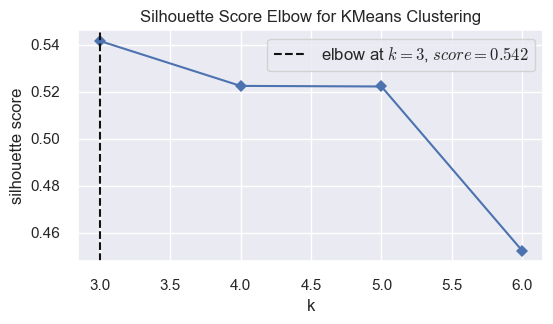

In [65]:
plt.figure(figsize = (6,3));
kmeans_viz = KElbowVisualizer(KMeans(n_init=10, random_state=0), k=clusters, metric='silhouette', timings=False );
kmeans_viz.fit(df_seg);
kmeans_viz.show();

A avaliação dos modelos será dada pela métrica Silhouette Score (SS), que pode ser utilizada para avaliar diferentes clusterizadores.
- A Silhueta (S) é a distância média do ponto em relação aos demais (do mesmo cluster, e de fora dele). A silhuette score é a média de todas as silhuetas de todos os pontos.

A SS mede portanto as duas propriedades que definem uma boa clusterização: 
- A compactação dos clusters (compactness): a distância entre os pontos do mesmo cluster deve ser a menor possível.
- A separação entre os clusters (separation): a distância entre os pontos de clusters diferentes deve ser a maior possível.

Dado que a SS varia entre 0 e 1, quando mais próximo de 1, melhor pode ser considerada a clusterização, considerando as propriedades acima.

A SS do K-Means com k=3 foi levemente superior neste primeiro ciclo. Todavia, pode ser interessante gerar um número maior de grupos de perfil de renda e idade ao time de marketing.

Considerando 4 grupos, foi obtida uma SS maior que 0.5 neste primeiro ciclo, o que é aceitável. Possivelmente a métrica pode ser melhorada, por meio de:
- Reescala de dados.
- Avaliação da presença de outliers, que podem distorcer os cálculos de distâncias.
- Tunagem de hiperparâmetros no modelo.
- Feature engeneering a partir 6 features de perfil de renda e idade do público alvo, buscando melhorar o espaço de dados. 
- Novos algoritmos com diferentes abordagens de clusterização.

Vamos abaixo treinar um K-Means com k=4 para avançar neste ciclo, e salvar suas previsões em uma variávels. 
Nos próximos ciclos, os tópicos acima serão abordados. 



In [66]:
kmeans = KMeans( n_clusters=4, #número de clusters
                  n_init=10, #número de vezes que o k-means irá com diferentes centroid seeds
                 random_state=0) #seed, para gerar a mesma inicialização aleatória
kmeans.fit(df_seg)
labels_kmeans = kmeans.labels_
labels_kmeans[:5]

array([3, 0, 3, 2, 0], dtype=int32)

In [67]:
#this method of k-means (sklearn) returns the SS
print(f"Silhouette Score com k=4: {round(silhouette_score(df_seg, labels_kmeans, metric='euclidean'),2)}") 

Silhouette Score com k=4: 0.52


### K-Means - Perfis dos Clusters

Criar um dataset contendo o grupo a que cada bairro pertence. 

In [68]:
df_seg.columns

Index(['pop_de25a34', 'pop_de35a49', 'domicilios_a1', 'domicilios_a2',
       'domicilios_b2', 'domicilios_b2'],
      dtype='object')

In [70]:
df_kmeans = df_sp.copy()
df_kmeans = df_kmeans[['bairro', 'pop_de25a34', 'pop_de35a49', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1', 'domicilios_b2']]
df_kmeans['cluster'] = labels_kmeans
df_kmeans.head(3)

,bairro,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,cluster
160,A. E. Carvalho,14535,21549,0,253,2197,4368,3
161,Aclimação,5341,7281,1413,1734,3704,2351,0
162,Adventista,17749,23364,0,0,1423,4875,3


Avaliar a quantidade e percentual de bairros por cluster.

In [72]:
df_kmeans_prof = df_kmeans[['bairro', 'cluster']].groupby('cluster').count().reset_index()
df_kmeans_prof['perc_bairros'] = df_kmeans_prof['bairro'] / df_kmeans_prof['bairro'].sum()*100
df_kmeans_prof

,cluster,bairro,perc_bairros
0,0,104,35.135135
1,1,12,4.054054
2,2,132,44.594595
3,3,48,16.216216


Na sequência, serão calculadas as médias dos features, para representar o centroide dos grupos. 

Desta forma, será possível compreender o perfil de renda e idade dos bairros. 

In [73]:
#média da feature pop_de25a34
df_avg_pop_de25a34 = df_kmeans[['pop_de25a34','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_pop_de25a34, how='inner', on='cluster')

#média da feature pop_de35a49
df_avg_pop_de35a49 = df_kmeans[['pop_de35a49','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_pop_de35a49, how='inner', on='cluster')

#média da feature domicilios_a1
df_avg_domicilios_a1 = df_kmeans[['domicilios_a1','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_a1, how='inner', on='cluster')

#média da feature domicilios_a1
df_avg_domicilios_a2 = df_kmeans[['domicilios_a2','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_a2, how='inner', on='cluster')

#média da feature domicilios_b1
df_avg_domicilios_b1 = df_kmeans[['domicilios_b1','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_b1, how='inner', on='cluster')

#média da feature domicilios_b2
df_avg_domicilios_b2 = df_kmeans[['domicilios_b2','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_b2, how='inner', on='cluster')

df_kmeans_prof

,cluster,bairro,perc_bairros,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2
0,0,104,35.135135,6691.673077,9684.740385,493.375000,774.692308,2583.817308,2662.884615
1,1,12,4.054054,24031.166667,33197.500000,0.666667,212.583333,2674.250000,6423.166667
2,2,132,44.594595,2220.810606,3124.060606,525.075758,544.666667,1240.772727,860.787879
3,3,48,16.216216,13102.791667,18474.812500,45.020833,260.395833,2108.145833,4132.854167


Gerar relatório de perfil de renda e idade dos bairros.

In [75]:
for i in range(len(df_kmeans_prof['bairro'])):
    print(f""" Cluster {df_kmeans_prof['cluster'][i]}:
    -Número de bairros:     {df_kmeans_prof['bairro'][i]} ({round(df_kmeans_prof['perc_bairros'][i])}%) 
    -População 25-34 anos:  {round(df_kmeans_prof['pop_de25a34'][i])} ({round(df_kmeans_prof.pop_de25a34[i]/df_kmeans_prof.pop_de25a34.sum()*100)}%) 
    -População 35-49 anos:  {round(df_kmeans_prof['pop_de35a49'][i])} ({round(df_kmeans_prof.pop_de35a49[i]/df_kmeans_prof.pop_de35a49.sum()*100)}%)
    -Domicílios renda A1:   {round(df_kmeans_prof['domicilios_a1'][i])} ({round(df_kmeans_prof.domicilios_a1[i]/df_kmeans_prof.domicilios_a1.sum()*100)}%)
    -Domicílios renda A2:   {round(df_kmeans_prof['domicilios_a2'][i])} ({round(df_kmeans_prof.domicilios_a2[i]/df_kmeans_prof.domicilios_a2.sum()*100)}%)
    -Domicílios renda B1:   {round(df_kmeans_prof['domicilios_b1'][i])} ({round(df_kmeans_prof.domicilios_b1[i]/df_kmeans_prof.domicilios_b1.sum()*100)}%)
    -Domicílios renda B2:   {round(df_kmeans_prof['domicilios_b2'][i])} ({round(df_kmeans_prof.domicilios_b2[i]/df_kmeans_prof.domicilios_b2.sum()*100)}%) \n""")

 Cluster 0:
    -Número de bairros:     104 (35%) 
    -População 25-34 anos:  6692 (15%) 
    -População 35-49 anos:  9685 (15%)
    -Domicílios renda A1:   493 (46%)
    -Domicílios renda A2:   775 (43%)
    -Domicílios renda B1:   2584 (30%)
    -Domicílios renda B2:   2663 (19%) 

 Cluster 1:
    -Número de bairros:     12 (4%) 
    -População 25-34 anos:  24031 (52%) 
    -População 35-49 anos:  33198 (51%)
    -Domicílios renda A1:   1 (0%)
    -Domicílios renda A2:   213 (12%)
    -Domicílios renda B1:   2674 (31%)
    -Domicílios renda B2:   6423 (46%) 

 Cluster 2:
    -Número de bairros:     132 (45%) 
    -População 25-34 anos:  2221 (5%) 
    -População 35-49 anos:  3124 (5%)
    -Domicílios renda A1:   525 (49%)
    -Domicílios renda A2:   545 (30%)
    -Domicílios renda B1:   1241 (14%)
    -Domicílios renda B2:   861 (6%) 

 Cluster 3:
    -Número de bairros:     48 (16%) 
    -População 25-34 anos:  13103 (28%) 
    -População 35-49 anos:  18475 (29%)
    -Domicílios re

Através do relatório acima, podem ser identificados 4 grupos de bairros onde o perfil de renda e idade são mais homogêneos dentro de cada grupo. 

Referente a indicação dos grupos ou bairros com maior aderência ao público alvo, será feita nova análise no próximo ciclo, utilizando uma variável para população, e outra para renda, para simplificar a interpretação e tomada de decisão do time de negócio. 

## Seleção de Features

In [268]:
df_sp = pd.read_csv('../data/interim/df_sp_an1e2_done.csv', index_col=0)
df_seg = df_sp.copy()
print(df_seg.shape)
df_seg.head(1)

(296, 24)


,codigo,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501,NaN,NaN


A análise deve ser baseada na faixa etária e perfil de renda do publico alvo. No ciclo 1, utilizou-se apenas as 6 features do público alvo para a clusterização.

Neste, serão consideradas as demais features relacionadas a população e domicilios (renda), a fim de identificar aqueles com maior aderência ao público alvo através da clusterização.

In [269]:
df_seg.columns

Index(['codigo', 'bairro', 'cidade', 'estado', 'populacao', 'pop_ate9',
       'pop_de10a14', 'pop_de15a19', 'pop_de20a24', 'pop_de25a34',
       'pop_de35a49', 'pop_de50a59', 'pop_mais_de60', 'domicilios_a1',
       'domicilios_a2', 'domicilios_b1', 'domicilios_b2', 'domicilios_c1',
       'domicilios_c2', 'domicilios_d', 'domicilios_e', 'renda_media',
       'faturamento', 'potencial'],
      dtype='object')

In [270]:
feat_selected = [ 'pop_ate9', 'pop_de10a14', 'pop_de15a19', 'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
        'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1', 'domicilios_b2', 'domicilios_c1',
       'domicilios_c2', 'domicilios_d', 'domicilios_e' ]

In [271]:
df_seg = df_seg[feat_selected].copy()
df_seg.head(1)

,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e
160,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670


## Comparação com o Baseline

Montando um novo cenário entre 3 e 6 grupos.

### Hyperparameter Fine-Tuning

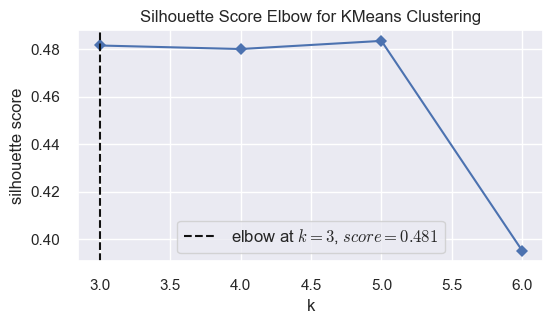

In [272]:
clusters = [3,4,5,6]
plt.figure(figsize = (6,3));
kmeans_viz = KElbowVisualizer(KMeans(n_init=10, random_state=0), k=clusters, metric='silhouette', timings=False );
kmeans_viz.fit(df_seg);
kmeans_viz.show();

A performance até piorou um pouco em relação ao ciclo 1.

Será avaliado abaixo este mesmo cenário, mas com as features resescaladas, visando melhorar esta SS.

## Reescala de Dados

In [273]:
df_seg.head(1)

,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e
160,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670


Todos os dados são numéricos, logo será aplicada uma reescala nos dados.

Analiar as distribuições das variáveis, a fim de definir o melhor scaler.

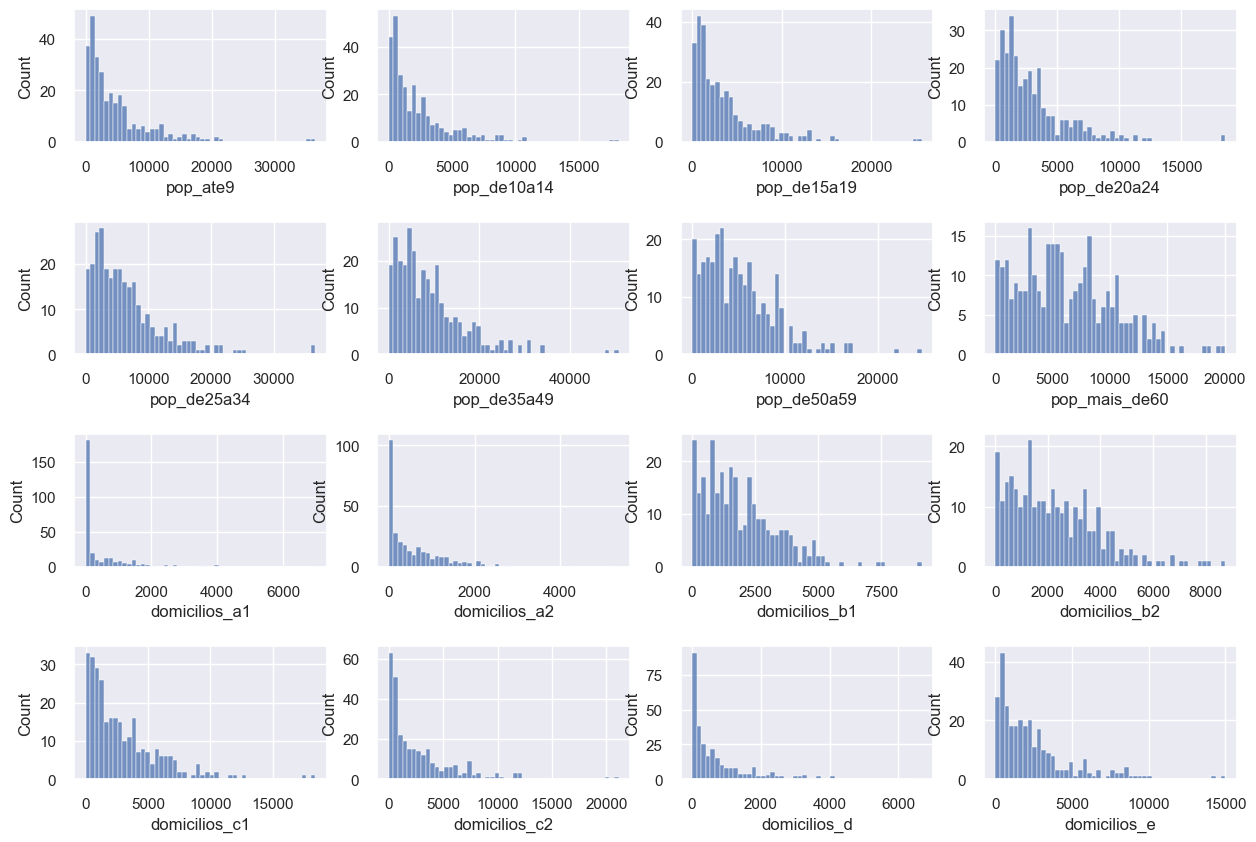

In [274]:
fig, axes = plt.subplots(nrows=4, ncols=4) 
axes = axes.flatten()
fig.set_size_inches(15, 10)
for ax, col in zip(axes, df_seg.columns):
    sns.histplot(df_seg[col], ax = ax, bins=50)
    plt.subplots_adjust(hspace=0.6)

Nenhuma delas possui distribuição normal. Será utilizado portanto o MinMaxScaler para todas.

In [275]:
df_seg_scaled = df_seg.copy()

In [276]:
scaler = MinMaxScaler()
df_seg_scaled[feat_selected] = scaler.fit_transform(df_seg_scaled[feat_selected])

In [277]:
df_seg_scaled.head(1)

,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e
160,0.3481,0.3772,0.3837,0.4042,0.3974,0.4244,0.4281,0.5245,0.0000,0.0472,0.2411,0.4995,0.3630,0.3320,0.3364,0.3780


### Hyperparameter Fine-Tuning

Nova avaliação de cenário, agora com features reescaladas.

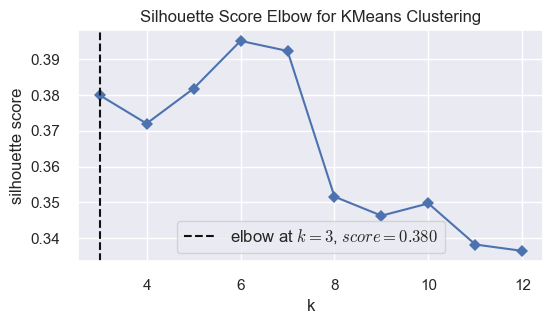

In [278]:
clusters = [3,4,5,6,7,8,9,10,11,12]
#[2,5,10,15,20,25,30] 
plt.figure(figsize = (6,3));
kmeans_viz_scaled = KElbowVisualizer(KMeans(n_init='auto', random_state=0), k=clusters, metric='silhouette', timings=False );
kmeans_viz_scaled.fit(df_seg_scaled);
kmeans_viz_scaled.show();

## Treinamento de Modelos - K-Means

Neste ciclo, será avançado considerando k=10, e melhorias serão implementadas nos próximos.

In [281]:
k = 10
kmeans = KMeans( #init='random', #init centroids ramdomly
                  n_clusters=k, #3
                  n_init='auto', #Num of times k-means will be run with different centroid seeds.
                  max_iter=300, #up to 300 times
                 random_state=0) #seed, to generate the same random init
kmeans.fit(df_seg_scaled)
#get cluster of each row
labels = kmeans.labels_

Análise da SS Score.

In [282]:
print(f'SS Score: {silhouette_score(df_seg_scaled, labels, metric="euclidean")}')

SS Score: 0.3497188181777718


## Análise de Silhueta

Na sequência, será realizada uma análise de silhueta. 

O objetivo é gerar figuras (shapes) que ilustrem a "qualidade" da clusterização (compactação, e distância entre os Ks) na alta dimensionalidade (mais de 3 clusters), tendo em vista que só conseguimos plotar graficamente até 3D. 
- Será utilizado o pacote "SilhouetteVisualizer" para isto. 

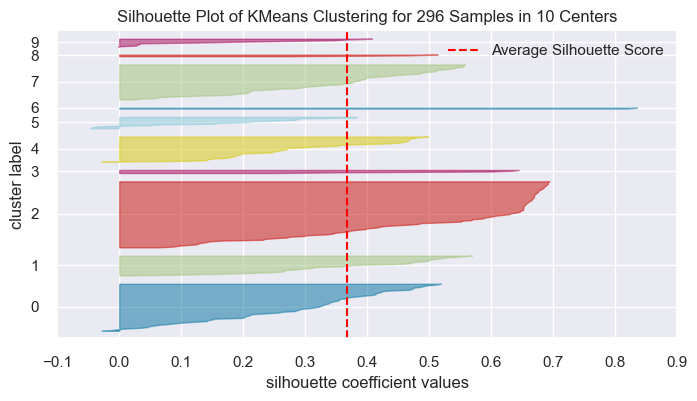

In [284]:
plt.figure(figsize = (8,4));
model = KMeans(10, random_state=42, n_init='auto')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_seg_scaled) 
visualizer.show();

Considerações:
- Se há pontos com valores negativos, deveriam pertencer a outros clusters. 
    - Foram identificados poucas incidências em poucos clusters.
- Quanto mais quadrada a ponta direita do shape for, mais condensado e distante dos outros ele está, logo melhor é a qualidade daquele cluster. 
    - A qualidade dos clusters pode melhorar, conforme mostram os shapes. Isto será trabalhado nos próximos ciclos.

## Perfis dos Clusters - K-Means

In [285]:
df_kmeans = df_seg.copy()
df_kmeans['cluster'] = labels
df_kmeans['bairro'] = df_sp.bairro
df_kmeans.head(1)

,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,cluster,bairro
160,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,3,A. E. Carvalho


Avaliar a quantidade e percentual de bairros por cluster.

In [286]:
df_kmeans_prof = df_kmeans[['bairro', 'cluster']].groupby('cluster').count().reset_index()
df_kmeans_prof['perc_bairros'] = df_kmeans_prof['bairro'] / df_kmeans_prof['bairro'].sum()*100

In [287]:
df_kmeans_prof[:3]

,cluster,bairro,perc_bairros
0,0,13,4.3919
1,1,24,8.1081
2,2,65,21.9595


Na sequência, serão calculadas as médias dos features, para representar o centroide dos grupos.

Desta forma, será possível compreender o perfil de renda e idade dos bairros.

In [288]:
#média da feature pop_de25a34
df_avg_pop_de25a34 = df_kmeans[['pop_de25a34','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_pop_de25a34, how='inner', on='cluster')

#média da feature pop_de35a49
df_avg_pop_de35a49 = df_kmeans[['pop_de35a49','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_pop_de35a49, how='inner', on='cluster')

#média da feature domicilios_a1
df_avg_domicilios_a1 = df_kmeans[['domicilios_a1','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_a1, how='inner', on='cluster')

#média da feature domicilios_a1
df_avg_domicilios_a2 = df_kmeans[['domicilios_a2','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_a2, how='inner', on='cluster')

#média da feature domicilios_b1
df_avg_domicilios_b1 = df_kmeans[['domicilios_b1','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_b1, how='inner', on='cluster')

#média da feature domicilios_b2
df_avg_domicilios_b2 = df_kmeans[['domicilios_b2','cluster']].groupby('cluster').mean().reset_index()
df_kmeans_prof = pd.merge(df_kmeans_prof, df_avg_domicilios_b2, how='inner', on='cluster')

Criar features alvo.

In [290]:
df_kmeans_prof["pop_alvo"] = df_kmeans_prof["pop_de25a34"] + df_kmeans_prof["pop_de35a49"]
df_kmeans_prof["domicilios_alvo"] = df_kmeans_prof["domicilios_a1"] + df_kmeans_prof["domicilios_a2"] + df_kmeans_prof["domicilios_b1"] + df_kmeans_prof["domicilios_b2"]

Ordenar por 'domicilios_alvo', sendo uma variável que concentra 4 das 6 que constituem o público alvo. 

In [292]:
df_kmeans_prof.sort_values(['domicilios_alvo'], ascending=False)

,cluster,bairro,perc_bairros,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,pop_alvo,domicilios_alvo
7,7,3,1.0135,18410.6667,28565.6667,229.6667,1420.3333,7188.0000,8208.6667,46976.3333,17046.6667
0,0,13,4.3919,6314.7692,9178.6154,2995.0769,2691.3846,4769.9231,2250.3846,15493.3846,12706.7692
5,5,2,0.6757,36493.5000,49529.5000,0.0000,0.0000,1486.5000,7681.5000,86023.0000,9168.0000
1,1,24,8.1081,10336.2917,14901.4583,75.0417,566.2917,3418.6667,4572.7500,25237.7500,8632.7500
9,9,8,2.7027,21967.5000,29952.0000,0.0000,48.6250,2083.1250,5613.5000,51919.5000,7745.2500
6,6,41,13.8514,5891.6585,8770.1951,496.9756,997.9512,3336.7561,2876.0244,14661.8537,7707.7073
8,8,62,20.9459,2941.5806,4237.8548,875.5323,908.4677,1975.2903,1213.4516,7179.4355,4972.7419
3,3,31,10.4730,13886.1613,19416.2903,1.1935,58.9032,1188.0000,3627.5806,33302.4516,4875.6774
4,4,47,15.8784,6961.8936,9716.7234,13.0213,146.7872,1215.1277,2248.8723,16678.6170,3623.8085
2,2,65,21.9595,1394.6308,1884.6923,93.1692,127.9846,420.1231,474.1231,3279.3231,1115.4000


Bairros sugeridos como tendo maior aderência abaixo.

In [296]:
df_kmeans.loc[df_kmeans.cluster == 7 ]

,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,cluster,bairro
311,10460,5343,8437,7250,15585,26002,15124,20034,681,2099,9111,7819,7147,5291,1331,5035,7,Mandaqui
382,15491,7279,11248,9278,20806,31195,16974,18736,0,1290,7360,8744,9817,7580,2429,7780,7,Sacomã
454,14670,7305,11225,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,7,Vila Zatt


Foram selecionados os 3 bairros com maior aderência neste ciclo, priorizando a feature 'domicilios_alvo'.

Atribui ao relatório de SP a variável 'maior_aderencia', junto das análises 1 e 2.

In [313]:
df_sp['cluster'] = labels
df_sp['maior_aderencia'] = df_sp.cluster.apply(lambda x: 'Sim' if x==7 else 'Não')
df_sp = df_sp.drop('cluster', axis=1)
df_sp.tail(3)

,codigo,bairro,cidade,estado,populacao,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial,maior_aderencia
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,26592,12579,13109,0,0,1758,4517,9450,11473,3218,7540,1252,140370.0500,Alto,Não
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,1936,260146.4500,Alto,Sim
455,355030164,Vista Alegre,São Paulo,SP,106,23,7,15,11,15,26,4,5,0,0,0,6,9,8,2,4,1288,810818.7000,Baixo,Não


Salvar relatório contendo as respostas das 3 análises.

In [314]:
df_sp.to_csv('../data/interim/df_sp_an1e2e3_done.csv')

# 4 - Lições aprendidas

Lições aprendidas até o ciclo 5:

- Em projetos com mais de um problema de negócio (caso deste, com 3 análises), desenvolver notebooks distintospara cada análise, visando maior organização.
- Tratar as features de produção (df_sp neste caso) conforme for desenvolvendo o projeto, pra dispensando tratativas na hora de criar o modelo final. 
- Caso não utilize pipelines, a seguinte ordem dos passos (para cada análise) desde o início facilita o desenvolvimento: 1) Split de dados (antes da modelagem, para evitar data leakeage), 2) Modelagem (fit_transform no treino, transforme em val, test e dado prod) 3) Feature Selection (deve ser após o split, pois ao utilizar modelos, requerem train e val).
    
PS: Discutir os tópicos com outros cientistas de dados, para obter suas perspectivas baseadas na sua experiência.

# 5  - Melhorias para próximos ciclos

Análise 1 (regressão):
- Realização de análise de resíduos com base nas métricsa de erros.
- Tratativa da variável resposta, normalizando ela (Response Variable Transformation).

Análise 2 (classificação):
- Gerar tabela de contingência e inspecionar detalhes de erros e acertos por classes, e métricas precision e recall.

Análise 3 (clusterização):
- Obtenção de coordenadas geográficas de cada bairro de São Paulo indicado com "maior_aderencia", e plot em mapa.
- Treinamento de novos algoritmos: Gaussian Mixture Model, Hierarchical Clustering, DBScan.
- Busca de um espaço espaço de embedding mais organizado com PCA, UMAP, t-SNE, ou um tree based model.

Geral:
- Coleta de novas features, e avaliação de aumento da performance dos modelos finais.
- Criação e validação de hipóteses, e geração de insights ao time de negócio.
- Implementar pipelines para data preparation, model training e cross validation, simplificando o processo.